<a href="https://colab.research.google.com/github/Prashanna-Raj-Pandit/NN-Time-series/blob/main/gait_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-129a970b-84fe-8365-47ba-90fff910a6c0)


# Processing IGAIT data

In [6]:
from re import sub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
side_df  = pd.read_csv("side_dataset_time_series.csv")
front_df = pd.read_csv("front_dataset_time_series.csv")
uni_df = pd.read_csv("univariate_data.csv")
# Encode categorical directions
side_map  = {'left':0, 'right':1, 'stationary':2}
front_map = {'towards':0, 'backwards':1}
side_df['DirCode']  = side_df['Direction'].map(side_map)
front_df['DirCode'] = front_df['Direction'].map(front_map)

# print(side_df.head())


# Get sorted list of subjects
subjects = sorted(side_df['subject'].unique())
n = len(subjects)  # 53

# Prepare arrays: side(53,300,9), front(53,249,4)
side_data  = np.zeros((n, 300, 9))
front_data = np.zeros((n, 249, 4))
for i, subj in enumerate(subjects):
    sub_side  = side_df[side_df['subject']==subj].sort_values('frame')
    sub_front = front_df[front_df['subject']==subj].sort_values('frame')
    # print(sub_side[['DirCode']].to_numpy()[:10])
    # print(sub_side[num_cols_side].to_numpy()[:10])
    # Side view: 8 numeric columns + DirCode
    num_cols_side = ['RightHipAngle','LeftHipAngle','RightKneeAngle','LeftKneeAngle',
                     'Right Ankle Angle','Left Ankle Angle','Right Dorsi Plantar Angle','Left Dorsi Plantar Angle']
    side_feat = np.hstack([sub_side[['DirCode']].to_numpy(), sub_side[num_cols_side].to_numpy()])
    # print(side_feat[0])
    # print(side_feat.shape)
    # Pad/truncate to 300 frames
    L = side_feat.shape[0]
    if L >= 300:
        side_data[i] = side_feat[:300]
    else:
        side_data[i] = np.vstack([side_feat, np.zeros((300-L, 9))])
    # Front view: 3 numeric columns + DirCode
    num_cols_front = ['R_Adduction_Abduction','L_Adduction_Abduction','Step_Width']
    front_feat = np.hstack([sub_front[['DirCode']].to_numpy(), sub_front[num_cols_front].to_numpy()])
    Lf = front_feat.shape[0]
    if Lf >= 249:
        front_data[i] = front_feat[:249]
    else:
        front_data[i] = np.vstack([front_feat, np.zeros((249-Lf, 4))])

# Create univariate features: e.g. mean step width, mean right hip, mean left hip
uni_features = []
for subj in subjects:
    cadence = uni_df[uni_df['Subject']==subj]['Cadence']
    step_length = uni_df[uni_df['Subject']==subj]['StepLength']
    stride_lenght = uni_df[uni_df['Subject']==subj]['StrideLength']
    # print(cadence,step_length,stride_lenght)
    uni_features.append([cadence, step_length, stride_lenght])
# uni_features = np.array(uni_features)  # shape (53,3)

# print(uni_features)
# print(uni_features.shape)
# Labels per subject (assumed consistent across datasets)
labels = np.array([int(side_df[side_df['subject']==subj]['label'].iloc[0]) for subj in subjects])

# Split into train/test
X_side_train, X_side_test, X_front_train, X_front_test, X_uni_train, X_uni_test, y_train, y_test = train_test_split(
    side_data, front_data, uni_features, labels, test_size=0.2, random_state=42,stratify=labels)


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
side_df  = pd.read_csv("side_dataset_time_series.csv")
front_df = pd.read_csv("front_dataset_time_series.csv")
uni_df = pd.read_csv("univariate_data.csv")

# Encode categorical directions
side_map  = {'left': 0, 'right': 1, 'stationary': 2}
front_map = {'towards': 0, 'backwards': 1}
side_df['DirCode']  = side_df['Direction'].map(side_map)
front_df['DirCode'] = front_df['Direction'].map(front_map)

# Sorted list of subjects
subjects = sorted(side_df['subject'].unique())
n = len(subjects)  # e.g., 53 subjects
print(f"Subjects: {n}")

# Initialize arrays
side_data  = np.zeros((n, 300, 9))
front_data = np.zeros((n, 249, 4))
uni_features = []

for i, subj in enumerate(subjects):
    # Side data
    sub_side  = side_df[side_df['subject'] == subj].sort_values('frame')
    num_cols_side = ['RightHipAngle', 'LeftHipAngle', 'RightKneeAngle', 'LeftKneeAngle',
                     'Right Ankle Angle', 'Left Ankle Angle',
                     'Right Dorsi Plantar Angle', 'Left Dorsi Plantar Angle']
    side_feat = np.hstack([sub_side[['DirCode']].to_numpy(), sub_side[num_cols_side].to_numpy()])
    L = side_feat.shape[0]
    side_data[i] = side_feat[:300] if L >= 300 else np.vstack([side_feat, np.zeros((300 - L, 9))])

    # Front data
    sub_front = front_df[front_df['subject'] == subj].sort_values('frame')
    num_cols_front = ['R_Adduction_Abduction', 'L_Adduction_Abduction', 'Step_Width']
    front_feat = np.hstack([sub_front[['DirCode']].to_numpy(), sub_front[num_cols_front].to_numpy()])
    Lf = front_feat.shape[0]
    front_data[i] = front_feat[:249] if Lf >= 249 else np.vstack([front_feat, np.zeros((249 - Lf, 4))])

    # Univariate features
    row = uni_df[uni_df['Subject'] == subj]
    cadence = row['Cadence'].values[0]
    step_length = row['StepLength'].values[0]
    stride_length = row['StrideLength'].values[0]
    uni_features.append([cadence, step_length, stride_length])

# Convert to NumPy array
uni_features = np.array(uni_features)  # shape: (53, 3)

# Labels
labels = np.array([int(side_df[side_df['subject'] == subj]['label'].iloc[0]) for subj in subjects])

# Train-test split
X_side_train, X_side_test, X_front_train, X_front_test, X_uni_train, X_uni_test, y_train, y_test = train_test_split(
    side_data, front_data, uni_features, labels,
    test_size=0.2, random_state=42, stratify=labels
)


Subjects: 53


In [24]:
X_side_train[0][0], X_side_train.shape, X_side_test[0],X_side_test.shape

(array([ 0.000e+00,  1.224e+01,  1.330e+00,  7.930e+00,  8.090e+00,
         1.082e+02,  9.809e+01,  0.000e+00, -1.000e-01]),
 (42, 300, 9),
 array([[ 1.0000e+00,  8.0000e-02,  1.0000e-02, ...,  1.0979e+02,
          0.0000e+00, -2.0000e-02],
        [ 0.0000e+00,  1.4600e+00,  1.0000e-02, ...,  1.0710e+02,
          0.0000e+00, -4.0000e-02],
        [ 0.0000e+00,  1.4600e+00,  1.3800e+00, ...,  1.0972e+02,
          0.0000e+00, -3.0000e-02],
        ...,
        [ 0.0000e+00,  1.0460e+01,  1.5790e+01, ...,  1.1148e+02,
          3.1400e+00,  8.3600e+00],
        [ 0.0000e+00,  1.1900e+01,  2.1040e+01, ...,  1.0261e+02,
         -1.0000e-02,  1.7630e+01],
        [ 0.0000e+00,  1.4780e+01,  2.1090e+01, ...,  1.0418e+02,
         -4.0000e-02,  2.7890e+01]]),
 (11, 300, 9))

In [25]:
X_front_train[0][0],X_front_train.shape,X_front_test.shape,

(array([  0.  , -12.55,  -0.06,  17.78]), (42, 249, 4), (11, 249, 4))

In [17]:
X_uni_train,X_uni_train.shape

(array([[1.86, 2.32, 4.65],
        [1.87, 2.74, 5.49],
        [2.18, 2.15, 4.31],
        [1.9 , 2.28, 4.55],
        [1.88, 2.32, 4.63],
        [2.1 , 2.  , 4.  ],
        [2.16, 2.  , 3.99],
        [2.08, 1.44, 2.89],
        [2.37, 1.49, 2.98],
        [1.89, 2.08, 4.16],
        [2.1 , 2.28, 4.55],
        [1.96, 1.55, 3.1 ],
        [2.  , 3.5 , 7.  ],
        [2.23, 1.46, 2.91],
        [1.99, 1.75, 3.5 ],
        [2.14, 2.21, 4.41],
        [1.59, 2.73, 5.46],
        [2.27, 1.7 , 3.4 ],
        [2.01, 1.63, 3.25],
        [2.1 , 2.1 , 4.  ],
        [2.26, 2.04, 4.08],
        [1.85, 1.83, 3.67],
        [1.91, 1.69, 3.39],
        [2.16, 1.64, 3.28],
        [1.99, 2.6 , 5.19],
        [1.84, 2.28, 4.56],
        [1.9 , 2.19, 4.37],
        [2.18, 1.76, 3.53],
        [2.19, 1.67, 3.34],
        [1.84, 1.38, 2.77],
        [2.28, 2.13, 4.27],
        [2.03, 1.51, 3.02],
        [2.14, 1.84, 3.67],
        [2.04, 1.22, 2.43],
        [2.28, 1.66, 3.32],
        [1.95, 1.96,

In [18]:
y_train[:20]

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1])

# Model Architecture


In [19]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, GlobalAveragePooling1D,
                                     Dense, Dropout, BatchNormalization, Activation, concatenate)
from tensorflow.keras.models import Model

# Side-view subnetwork
side_input = Input(shape=(300, 9), name='side_input')
x_side = Conv1D(32, 3, activation=None)(side_input)
x_side = BatchNormalization()(x_side)
x_side = Activation('relu')(x_side)
x_side = MaxPooling1D(2)(x_side)

x_side = Conv1D(64, 3, activation=None)(x_side)
x_side = BatchNormalization()(x_side)
x_side = Activation('relu')(x_side)
x_side = GlobalAveragePooling1D()(x_side)

# Front-view subnetwork
front_input = Input(shape=(249, 4), name='front_input')
x_front = Conv1D(16, 3, activation=None)(front_input)
x_front = BatchNormalization()(x_front)
x_front = Activation('relu')(x_front)
x_front = MaxPooling1D(2)(x_front)

x_front = Conv1D(32, 3, activation=None)(x_front)
x_front = BatchNormalization()(x_front)
x_front = Activation('relu')(x_front)
x_front = GlobalAveragePooling1D()(x_front)

# Univariate-features subnetwork
uni_input = Input(shape=(3,), name='uni_input')
x_uni = Dense(32, activation=None)(uni_input)
x_uni = BatchNormalization()(x_uni)
x_uni = Activation('relu')(x_uni)
x_uni = Dropout(0.5)(x_uni)

x_uni = Dense(16, activation=None)(x_uni)
x_uni = BatchNormalization()(x_uni)
x_uni = Activation('relu')(x_uni)

# Concatenate all features
merged = concatenate([x_side, x_front, x_uni])
z = Dense(64, activation=None)(merged)
z = BatchNormalization()(z)
z = Activation('relu')(z)
z = Dropout(0.5)(z)

output = Dense(1, activation='sigmoid', name='output')(z)

# Build and compile model
model = Model(inputs=[side_input, front_input, uni_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ side_input          │ (None, 300, 9)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ front_input         │ (None, 249, 4)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 298, 32)   │        896 │ side_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 247, 16)   │        208 │ front_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ uni_input           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 298, 32)   │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 247, 16)   │         64 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ uni_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 298, 32)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 247, 16)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 149, 32)   │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 123, 16)   │          0 │ activation_2[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32)        │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 147, 64)   │      6,208 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 121, 32)   │      1,568 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 64)   │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 121, 32)   │        128 │ conv1d_3[0][0]  

 Total params: 17,857 (69.75 KB)

 Trainable params: 17,345 (67.75 KB)

 Non-trainable params: 512 (2.00 KB)

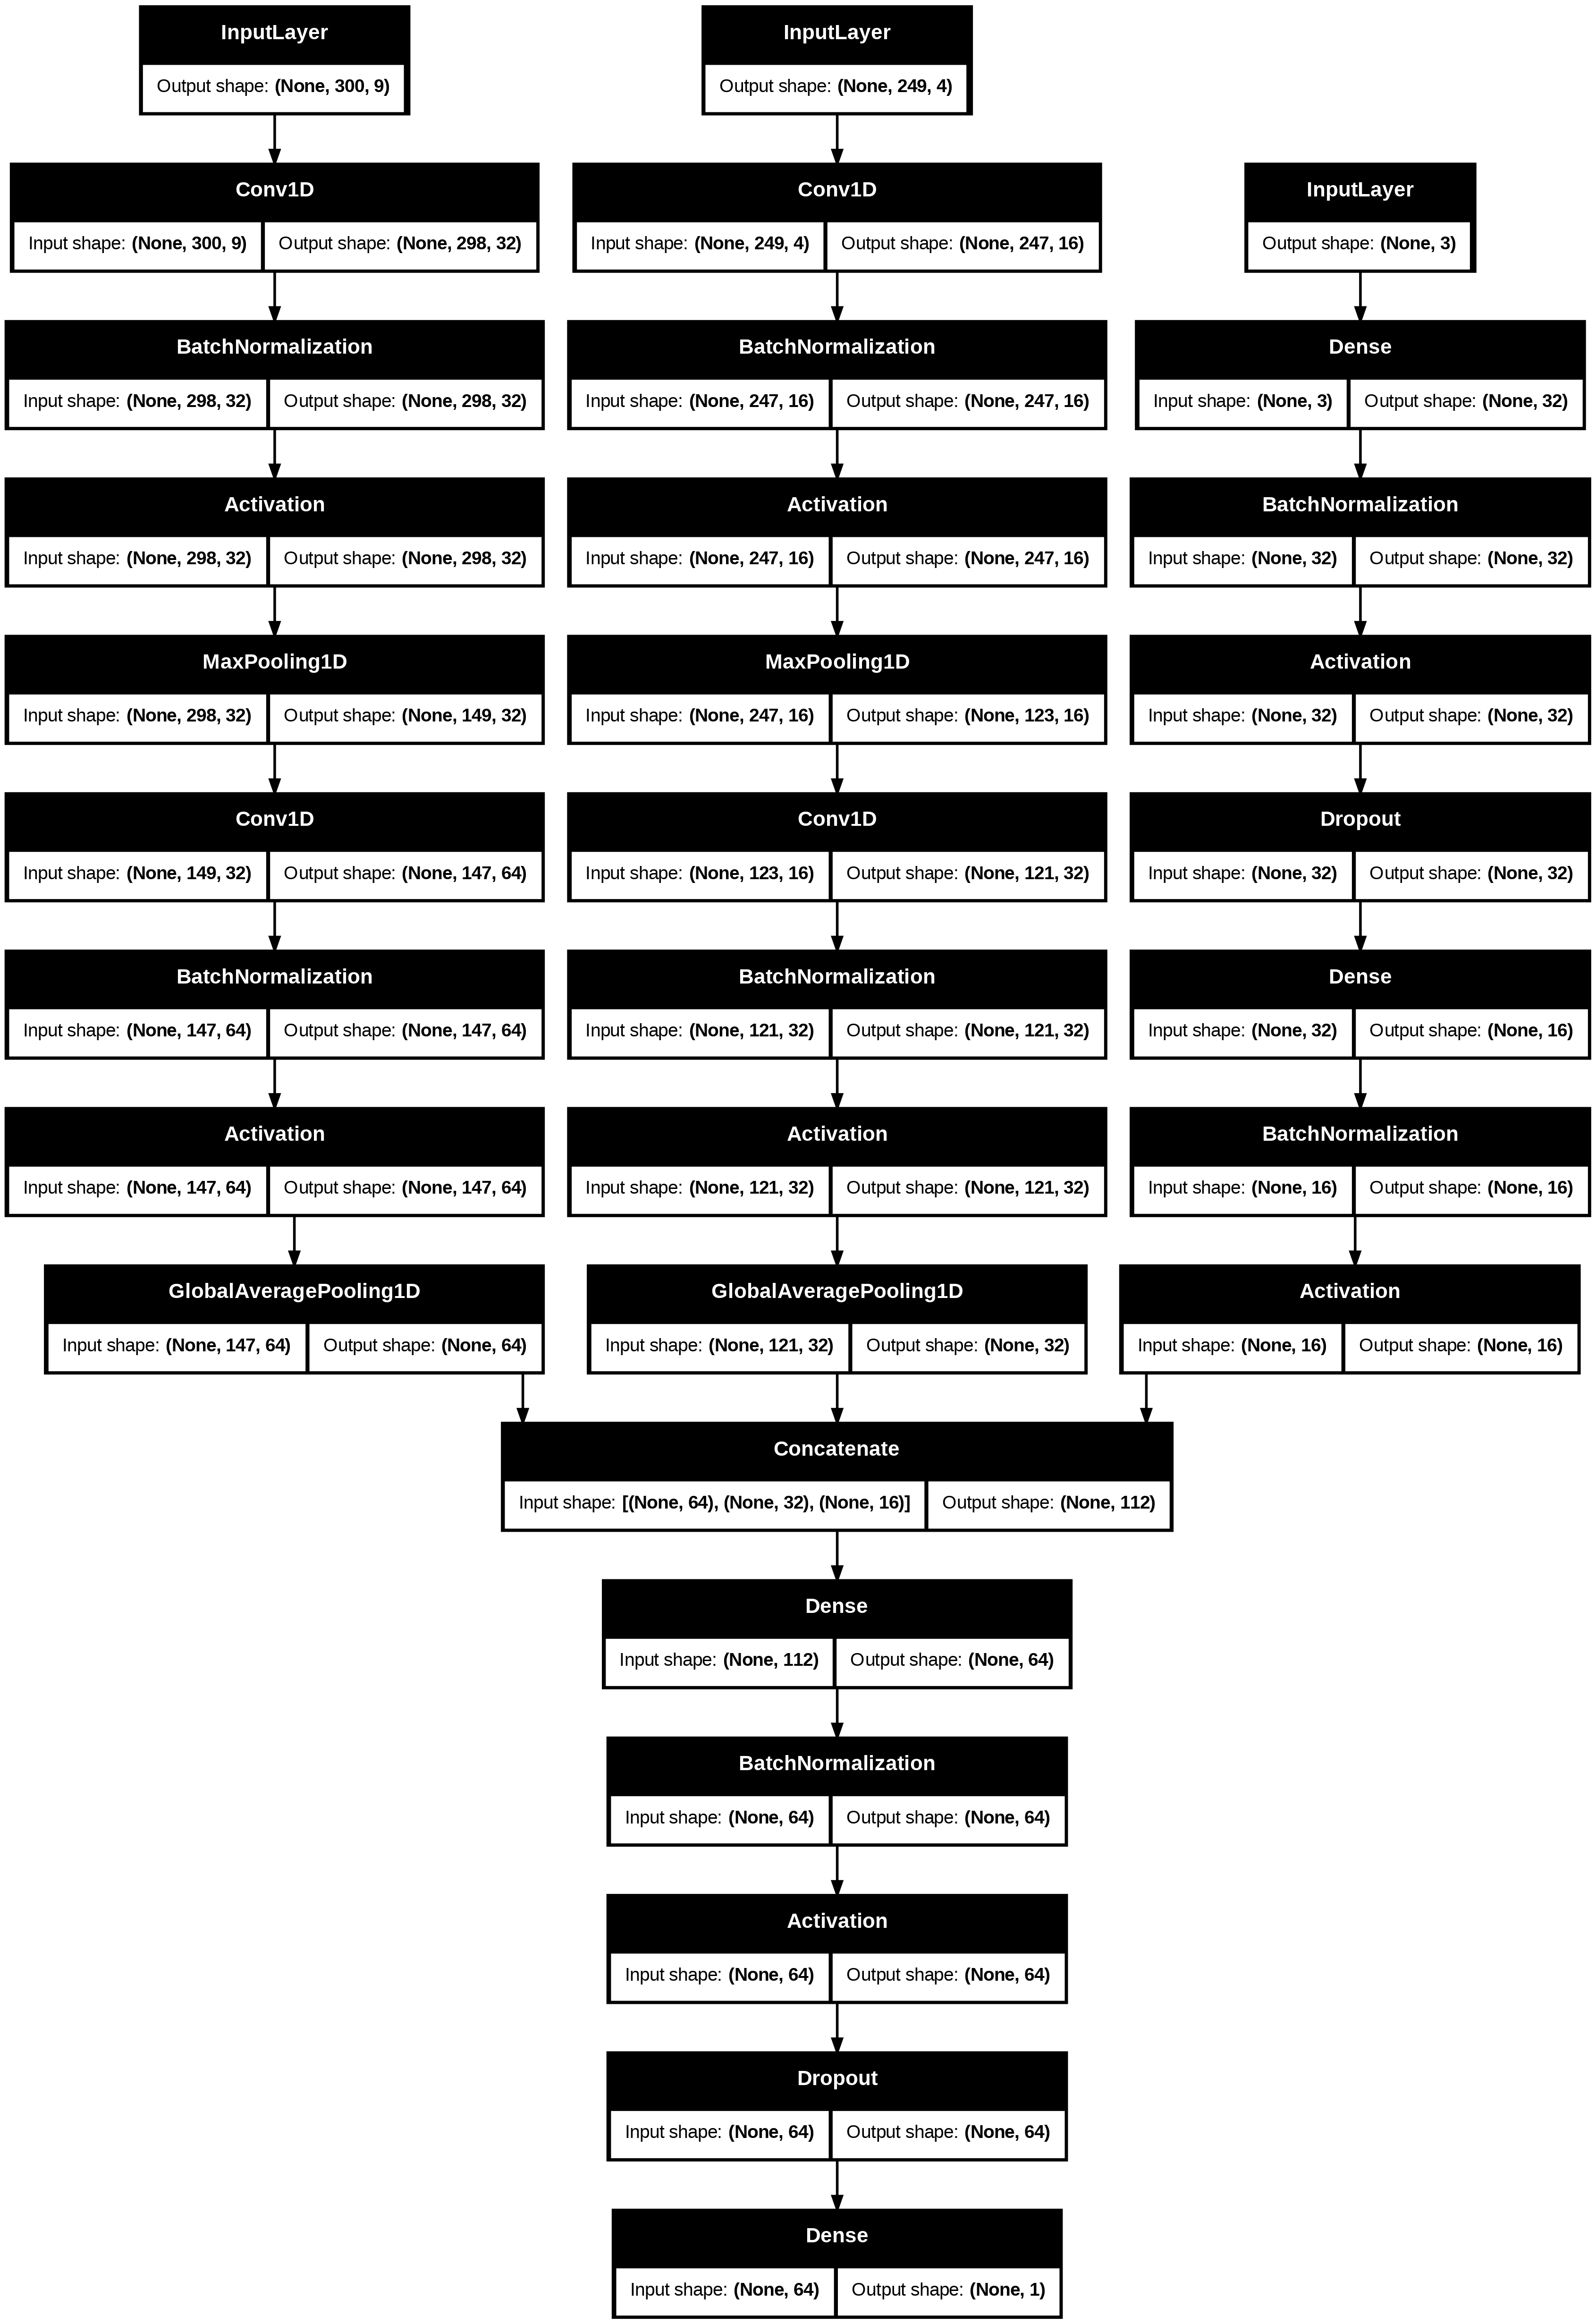

In [20]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [21]:
print("Side NaNs:", np.isnan(X_side_train).sum())
print("Front NaNs:", np.isnan(X_front_train).sum())
print("Uni NaNs:", np.isnan(X_uni_train).sum())

print("Side NaNs:", np.isnan(X_side_test).sum())
print("Front NaNs:", np.isnan(X_front_test).sum())
print("Uni NaNs:", np.isnan(X_uni_test).sum())
print("----------")
print("Side Infs:", np.isinf(X_side_train).sum())
print("Front Infs:", np.isinf(X_front_train).sum())
print("Uni Infs:", np.isinf(X_uni_train).sum())


print("Side Infs:", np.isinf(X_side_test).sum())
print("Front Infs:", np.isinf(X_front_test).sum())
print("Uni Infs:", np.isinf(X_uni_test).sum())


Side NaNs: 0
Front NaNs: 0
Uni NaNs: 0
Side NaNs: 0
Front NaNs: 0
Uni NaNs: 0
----------
Side Infs: 0
Front Infs: 0
Uni Infs: 0
Side Infs: 0
Front Infs: 0
Uni Infs: 0


# Training with Callbacks

In [22]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# Train the model
history = model.fit(
    [X_side_train, X_front_train, X_uni_train], y_train,
    validation_split=0.1,
    epochs=100,
    batch_size=8,
    callbacks=callbacks,
    verbose=1
)

# Save the final model
model.save('final_model.h5')


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5702 - loss: 0.6287  

5/5 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.5787 - loss: 0.6259 - val_accuracy: 0.0000e+00 - val_loss: 1.8166
Epoch 2/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6250 - loss: 0.7623

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5906 - loss: 0.7709 - val_accuracy: 0.0000e+00 - val_loss: 1.6324
Epoch 3/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6250 - loss: 0.7399

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5413 - loss: 0.7384 - val_accuracy: 0.0000e+00 - val_loss: 1.4839
Epoch 4/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7500 - loss: 0.4715

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.6357 - loss: 0.6232 - val_accuracy: 0.0000e+00 - val_loss: 1.3860
Epoch 5/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6250 - loss: 0.8853

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6384 - loss: 0.7410 - val_accuracy: 0.0000e+00 - val_loss: 1.3285
Epoch 6/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8750 - loss: 0.4161

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7551 - loss: 0.6056 - val_accuracy: 0.0000e+00 - val_loss: 1.2540
Epoch 7/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.7500 - loss: 0.6982

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7027 - loss: 0.5979 - val_accuracy: 0.0000e+00 - val_loss: 1.2089
Epoch 8/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5000 - loss: 0.6958

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6454 - loss: 0.6262 - val_accuracy: 0.0000e+00 - val_loss: 1.1361
Epoch 9/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8750 - loss: 0.4084

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8234 - loss: 0.4669 - val_accuracy: 0.0000e+00 - val_loss: 1.0668
Epoch 10/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7500 - loss: 0.7182

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7012 - loss: 0.7599 - val_accuracy: 0.2000 - val_loss: 0.9949
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7065 - loss: 0.5085 - val_accuracy: 0.2000 - val_loss: 1.0240
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6245 - loss: 0.6290 - val_accuracy: 0.2000 - val_loss: 1.0592
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7047 - loss: 0.4785 - val_accuracy: 0.4000 - val_loss: 1.0179
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6051 - loss: 0.5700 - val_accuracy: 0.4000 - val_loss: 1.0933
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6839 - loss: 0.5739 - val_accuracy: 0.0000e+00 - val_loss: 1.2119


# Loading and Making Predictions


In [23]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report

# Load the saved model
loaded_model = load_model('final_model.h5')

# Predict on test set
pred_probs = loaded_model.predict([X_side_test, X_front_test, X_uni_test])
pred_labels = (pred_probs.flatten() > 0.5).astype(int)

# Evaluate
acc = accuracy_score(y_test, pred_labels)
print(f"Test Accuracy: {acc:.3f}")

print("\nClassification Report:")
print(classification_report(y_test, pred_labels))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 909ms/step
Test Accuracy: 0.364

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.36      1.00      0.53         4

    accuracy                           0.36        11
   macro avg       0.18      0.50      0.27        11
weighted avg       0.13      0.36      0.19        11



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## 1st attempt:
Test Accuracy: 0.636

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11


## 2nd attempt ( filtered NAN data)
Test Accuracy: 0.455

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.40      1.00      0.57         4

    accuracy                           0.45        11
   macro avg       0.70      0.57      0.41        11
weighted avg       0.78      0.45      0.37        11

## 3rd attempt (Using Batch Normalization)
Test Accuracy: 0.455

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.40      1.00      0.57         4

    accuracy                           0.45        11
   macro avg       0.70      0.57      0.41        11
weighted avg       0.78      0.45      0.37        11

# 4th attempt (Using LSTM)
Test Accuracy: 0.364

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.57      0.53         7
           1       0.00      0.00      0.00         4

    accuracy                           0.36        11
   macro avg       0.25      0.29      0.27        11
weighted avg       0.32      0.36      0.34        11

## 5th attempt (Stratified sampling)

Test Accuracy: 0.636

Classification Report:
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       0.00      0.00      0.00         4

    accuracy                           0.64        11
   macro avg       0.32      0.50      0.39        11
weighted avg       0.40      0.64      0.49        11

<Axes: title={'center': 'Attempt 3- Batch Normalization'}>

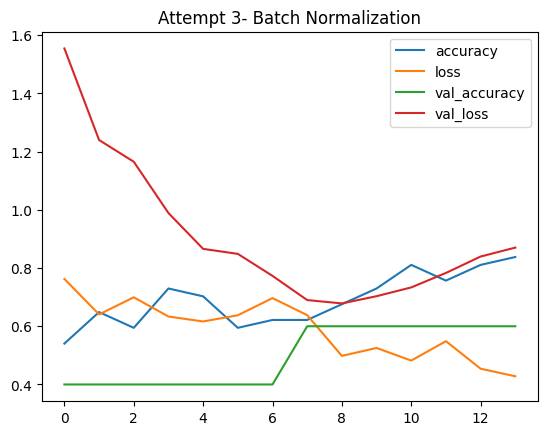

In [ ]:
pd.DataFrame(history.history).plot(title="Attempt 3- Batch Normalization")

<Axes: title={'center': 'Attempt 4- with LSTM'}>

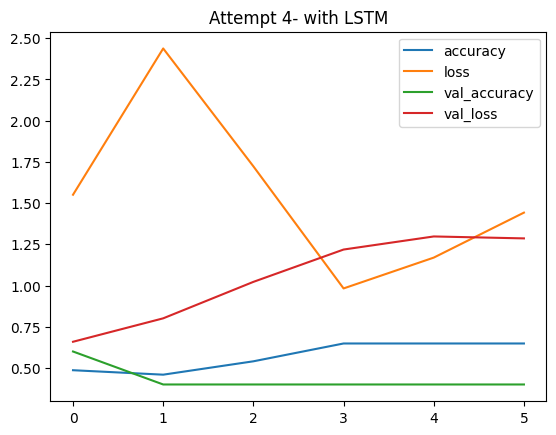

In [ ]:
pd.DataFrame(history.history).plot(title="Attempt 4- with LSTM")

<Axes: title={'center': 'Attempt 5- stratified sampling'}>

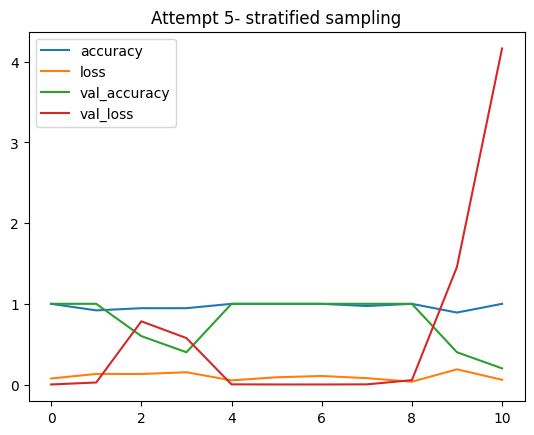

In [ ]:
pd.DataFrame(history.history).plot(title="Attempt 5- stratified sampling")

# ================================================================================

# Explanation

It prepares time-series data for each person into the shape expected by an LSTM model:

```python
X.shape → (num_samples, timesteps, num_features)  
y.shape → (num_samples,)
```

---

##  Step-by-Step Breakdown

```python
def prepare_sequences(df):
    grouped = df.groupby("sample_id")
```

###  `df.groupby("sample_id")`

This groups the dataframe by the **person ID** — each person (or sample) has a unique `sample_id`.

Assume your data looks like this:

| sample\_id | frame | feature1 | feature2 | ... | label         |
| ---------- | ----- | -------- | -------- | --- | ------------- |
| 0          | 0     | ...      | ...      |     | autistic      |
| 0          | 1     | ...      | ...      |     | autistic      |
| ...        | ...   | ...      | ...      |     | ...           |
| 1          | 0     | ...      | ...      |     | non\_autistic |

When you call:

```python
grouped = df.groupby("sample_id")
```

It organizes the data like:

```python
grouped = {
    0: DataFrame of 500 rows (frames) for person 0,
    1: DataFrame of 500 rows for person 1,
    ...
}
```

---

###  `for name, group in grouped:`

This loop goes through each group (i.e., each person’s 500-frame time series):

* `name`: the `sample_id` (e.g., 0, 1, 2, ...)
* `group`: the sub-DataFrame with 500 rows for that person

Sample Output:

```plaintext
name -> 0
group ->
   sample_id  frame  feature1  feature2  ...  label
0          0      0     ...       ...         autistic
1          0      1     ...       ...         autistic
...
499        0    499     ...       ...         autistic
```


###  `X.append(group[FEATURES].values)`

Here’s what happens:

* `FEATURES` is a list of your selected 11 features (e.g., knee\_angle, step\_width, etc.)
* `group[FEATURES].values` gives you a `(500, 11)` NumPy array
* You add that array to your list `X`

```python
X.append(group[FEATURES].values)  # shape: (500, 11)
```

---

###  `y.append(group["label"].values[0])`

Since the `label` is repeated in all 500 rows, we just take the **first** one:

```python
y.append(group["label"].values[0])  # 'autistic' or 'non_autistic'
```

So now:

* `X` is a list of shape `(num_samples, 500, 11)`
* `y` is a list of shape `(num_samples,)`

---

###  Final Return

```python
return np.array(X), np.array(y)
```

Let’s say you have 80 people:

```python
X.shape → (80, 500, 11)
y.shape → (80,)
```

Perfect for LSTM input!

---

##  Summary

| Component    | Shape/Type             | Purpose                                       |
| ------------ | ---------------------- | --------------------------------------------- |
| `groupby()`  | groups by person       | Makes it easy to loop over each person’s data |
| `X`          | `(n_samples, 500, 11)` | Time series input for LSTM                    |
| `y`          | `(n_samples,)`         | Class label for each person                   |
| `.values[0]` | scalar label           | All rows have same label, so pick first       |

In [ ]:
# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers
# from sklearn.model_selection import train_test_split

# # Load dataset
# time_series_df = pd.read_excel("train_gait_data.xlsx", sheet_name="time_series")
# static_df = pd.read_excel("train_gait_data.xlsx", sheet_name="static")

# FEATURES = [f"f{i}" for i in range(11)]

# def prepare_sequences(ts_df, static_df):
#     grouped = ts_df.groupby("sample_id")
#     X_seq, X_static, y = [], [], []

#     for sample_id, group in grouped:
#         X_seq.append(group[FEATURES].values)
#         static_row = static_df[static_df["sample_id"] == sample_id]
#         X_static.append(static_row[["cadence", "speed", "steps"]].values[0])
#         y.append(static_row["label"].values[0])

#     return np.array(X_seq), np.array(X_static), np.array(y)

# X_seq, X_static, y = prepare_sequences(time_series_df, static_df)

# # Split
# X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(
#     X_seq, X_static, y, test_size=0.2, stratify=y, random_state=42
# )

# # Model
# def create_model(seq_input_shape, static_input_shape):
#     seq_input = keras.Input(shape=seq_input_shape, name="sequence_input")
#     x = layers.Masking()(seq_input)
#     x = layers.LSTM(64)(x)
#     x = layers.Dropout(0.3)(x)
#     x = layers.Dense(32, activation="relu")(x)

#     static_input = keras.Input(shape=static_input_shape, name="static_input")
#     s = layers.Dense(16, activation="relu")(static_input)

#     combined = layers.Concatenate()([x, s])
#     z = layers.Dense(32, activation="relu")(combined)
#     z = layers.Dropout(0.3)(z)
#     output = layers.Dense(1, activation="sigmoid")(z)

#     return keras.Model(inputs=[seq_input, static_input], outputs=output)

# model = create_model(X_seq.shape[1:], X_static.shape[1:])
# model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# # Callbacks
# callbacks = [
#     keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor="val_loss"),
#     keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
#     keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, verbose=1)
# ]

# # Train
# history = model.fit(
#     {"sequence_input": X_seq_train, "static_input": X_static_train},
#     y_train,
#     validation_split=0.2,
#     epochs=100,
#     batch_size=8,
#     callbacks=callbacks
# )

# # Evaluate
# model.evaluate(
#     {"sequence_input": X_seq_test, "static_input": X_static_test},
#     y_test,
#     verbose=1
# )


In [5]:
import numpy as np

a = np.array([[1], [2], [3]])   # Shape (3, 1)
b = np.array([[4], [5], [6]])   # Shape (3, 1)

np.hstack((a, b))


array([[1, 4],
       [2, 5],
       [3, 6]])

In [1]:
import re

text = "apple orange apple banana"
new_text = re.sub("apple", "grape", text)
print(new_text)

grape orange grape banana
